# "Answer Business Questions with Data Science - SQL case study"
> "Using SQLite"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [SQL, business]
- image: images/SQL.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# 1. Introduction

## 1.1. Problem Definition

One of the most often ignored part of any data science project is defining which problem your code implementation is trying to solve. In engineering college I was trained to solve problems which were already framed for me – my task was just using a set of constrained manipulations to find the variable that was missing.  

In real life, problems does not appear in such organized manner. They are generally a fuzzy collection of useful and useless information on which we need to reflect upon and include what is important and exclude what is not.

Here, I will define the term **problem** as an offset between a *present state* and a *desired state*. What we do to go from a current to a desired state is the problem solution! The technology employed to solve the problem may vary depending on how you frame it and which solution path you choose. 

Next I will provide the context for the problem we will solve and derive a simple statement from it (simple subject + action verb + object). Than we can go from a broad description to a statement with a call for action:


**Context:** Suppose you are working on a digital media record store that sells tracks and entire albuns of several artists and music genres across several countries of the world. Supposing the record stores has made a deal with a record label. They claim that they have **FOUR INCREDIBLE ALBUNS** that will make a huge success in the **USA** and want to advertise them. However, we can only include three of them in the Store. These albuns are from four distinct genres which are already found in several tracks in our digital store - **'Hip Hop/Rap','Alternative & Punk','Pop','Blues'**

**Problem statement:** Select 3 out of 4 possible albuns to include in the digital store.

## 1.2. Solution Strategy

As you may noticed, there are several ways I can select 3 out of 4 albuns – each will recquire a certain amount of resources (time, technology). Let's assess them in this terms:

1.  Write the genres on pieces of paper, put them in a box, and draw 3 of them randomly - **Resources: low, Results: Probably poor**. 

2.  Try assigning a meaningful metric to each possible triplet of albuns and maximize/minimize it. **Resources: medium, Results: ok**.

Here I will choose the 2nd option since Data Science is about answering questions based on data and not lucky! Hopefully, this approach is better than pure chance. 

### The Data Base

The data base used is this analysis is the [Chinook](https://github.com/lerocha/chinook-database/blob/master/README.md) data model which represents a digital media store, including tables for artists, albums, media tracks, invoices and customers. A copy of the database schema is displayed below.

![chinook](https://raw.githubusercontent.com/viniviena/repositoryname/master/Chinook.png)

To implement the 2nd option we need a metric to assign for each triplet. In the database, we have few information we can use. Basically we want our choice to maximize the chance that the selected albuns will be sold as much as the ones we already have in our store. There are two words to pay attention: **"chance"** and **"will be sold"**. 

Chances triggers my mind to probability and counting - maybe using genre popularity is a way. About the the verb form "will be sold". It is too vague - when we talk about the future it is desirable to set a time frame (1 one month, pi years, 3.74 years).

As you may noticed, the database schema does not provide any time-related information about the invoices, albuns or artists. This could be valuable for deciding if something will be succesful in a near future. Even so, we can still use available information to guide our decision.  

If you notice, only one attribute of this new album was provided - their genre. We know that music has much more attributes than its genre - I know several artists that play songs from the same genre but sounds quite different. Even so, lets use what we have.

One approach to solve this problem is collecting information about the **popularity** or **total sales** of those genres in our store and pick the triplet which has the highest popularity.

This may seem a little biased since popularity vary over time and by lumping everything we can draw bad conclusions. However, this is the information we have at hand. **Here I'll use the total sales since it is correlated with popularity but it is easier to interpret and it is what guide any company (profit)** 


**Finally, we will choose 3 albuns for which the sum of total sales is maximized.**

# 2. Solution implementation

## 2.1. Importing modules

In [1]:
#collapse-hide
%matplotlib inline
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt

## 2.2. Creating support functions

1. `run_query()` - takes a SQL query as argument and returns a panda dataframe contaning the correspondent data.

2. `run_command()` - takes a SQL command and execute using sqlite module.

3. `show_tables()` - Function that calls run_query() function to return a list of all tables and views in the database.

In [2]:
#collapse-hide
# Function 1 runquery
def run_query(q):
    with sql.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)
    
#Function 2 run_command    
def run_command(c):
    with sql.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
#Function 3 show_tables

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In order to answer which three albuns include in the Store, we can create three queries:

* The **first subquery** join the *invoice, invoice_inline and customer* tables considering only customers from USA and return the `total` and `track_id` columns. 


* The **second subquery** join the *track* table with the *genre* table considering only the genres HIP-HOP,PUNK,POP and BLUES. it return `track_id` and `genre_name` columns. 


* The final query join the two queries and apply the `SUM()` operator in the total_USA column from subquery 1 and group by genre_name.

In [4]:
#Testing subqueries
#SQ1
sq1 = '''SELECT
            invl.track_id track_id,
            inv.total total_USA
            FROM customer c
            LEFT JOIN invoice inv ON c.customer_id = inv.customer_id
            LEFT JOIN invoice_line invl ON invl.invoice_id = inv.invoice_id
            WHERE c.country = "USA"
'''
print('The first ten rows of subquery 1 are')
table_q1 = run_query(sq1)
run_query(sq1).head(10)

The first ten rows of subquery 1 are


,track_id,total_USA
0,1435,6.93
1,1761,6.93
2,3377,6.93
3,1785,6.93
4,442,6.93
5,1951,6.93
6,2334,6.93
7,22,3.96
8,1488,3.96
9,1977,3.96


In [5]:
#calculating the sum of total invoices in the USA for all genres
sum_total = table_q1['total_USA'].sum()

In [6]:
#Testing Subqueries
#SQ2
sq2= '''    SELECT 
               t.track_id,
               g.name genre_name
               FROM genre g
               LEFT JOIN track t ON t.genre_id = g.genre_id
               WHERE genre_name IN ('Hip Hop/Rap','Alternative & Punk','Pop','Blues')

'''
print('the first 10 rows of subquery 2 are:')
run_query(sq2).head(10)

the first 10 rows of subquery 2 are:


,track_id,genre_name
0,99,Alternative & Punk
1,100,Alternative & Punk
2,101,Alternative & Punk
3,102,Alternative & Punk
4,103,Alternative & Punk
5,104,Alternative & Punk
6,105,Alternative & Punk
7,106,Alternative & Punk
8,107,Alternative & Punk
9,108,Alternative & Punk


In [7]:
#collapse-hide
#Final results
q1_sq1 = '''
        WITH sq1 AS 
        
            (
            SELECT
            invl.track_id track_id,
            inv.total total_USA
            FROM customer c
            LEFT JOIN invoice inv ON c.customer_id = inv.customer_id
            LEFT JOIN invoice_line invl ON invl.invoice_id = inv.invoice_id
            WHERE c.country = "USA"
                    ),
                    
            sq2 AS 
            
                (
               SELECT 
               t.track_id,
               g.name genre_name
               FROM genre g
               LEFT JOIN track t ON t.genre_id = g.genre_id
               WHERE genre_name IN ('Hip Hop/Rap','Alternative & Punk','Pop','Blues')
                )
                
            SELECT 
            sq1.track_id,
            sq2.genre_name,
            SUM(sq1.total_USA) total
            FROM sq1
            INNER JOIN sq2 ON sq2.track_id = sq1.track_id
            GROUP BY genre_name
            ORDER BY total DESC
 '''
final_results = run_query(q1_sq1)

print('the final query table is:')
final_results

the final query table is:


,track_id,genre_name,total
0,2327,Alternative & Punk,1234.53
1,896,Blues,453.42
2,3310,Hip Hop/Rap,366.30
3,3255,Pop,201.96


It is useful to include a column with the total purchased for each genre in percetage of the total purchased in the USA for all genres. Thus, a new column is introduced by applying the following equation:


$total(percent) = \frac{total}{sumtotal}$

In [8]:
final_results_perc = final_results.copy()
final_results_perc['total_%'] = final_results_perc['total']/sum_total*100
final_results_perc.set_index('genre_name',inplace=True)
final_results_perc

,track_id,total,total_%
genre_name,,,
Alternative & Punk,2327,1234.53,11.863762
Blues,896,453.42,4.357340
Hip Hop/Rap,3310,366.30,3.520122
Pop,3255,201.96,1.940824


## 3. Answering our question.

* The question can be answered using the final query table. However, we can say that this result could be part of a report in which the graphical display of information is very desirable. In this way, we can plot a bar chart displaying the results arised from question 1 as following:

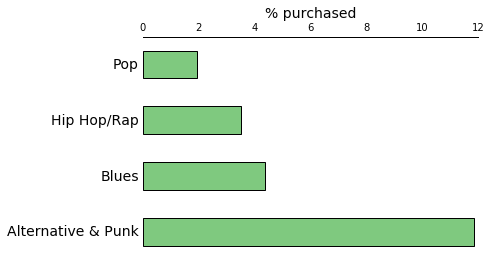

In [20]:
%matplotlib inline
a = final_results_perc.plot(kind='barh',
                        y='total_%',
                        colormap=plt.cm.Accent,
                        fontsize=14,
                        legend = False
                           )
#a.set_title('Which genres include in the Chinook Store?',loc='left',fontdict={'fontsize':14},color='grey')
a.set_xlabel('% purchased',fontsize=14)
a.xaxis.set_label_position('top')
a.set_ylabel('',fontsize=14)
a.xaxis.tick_top()
a.spines['right'].set_visible(False)
a.spines['bottom'].set_visible(False)
a.spines['left'].set_visible(False)
a.tick_params(axis='both', which='major',bottom='off',top = 'off',left='off',right='off')

## Conclusions

We framed the problem to be solved and mapped two possible solutions. Then, we pick up one that can give us an answer. However, it left several aspects behind that were briefly discussed.